<h1 id="header">BookMe Company</h1>

### Supervised Project

In [2]:
# Relevant Package Importing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import RFE
import scipy.stats as stats
from scipy.stats import chi2_contingency
# Scaling
from sklearn.preprocessing import MinMaxScaler
# Models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
# Model Assessment
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
import warnings
warnings.filterwarnings('ignore')

### Pre-Processing


In [3]:
#Import Data from cluster.csv
db = pd.read_csv('train.csv')
db[db.duplicated(keep = False)] # We don't have duplicates

,Cust_ID,Churn,Name,Longevity,Year_Birth,TypeTravel,RoomType,RewardPoints,Comfort,ReceptionSchedule,...,Wifi,Amenities,Staff,OnlineBooking,PriceQuality,RoomSpace,CheckOut,Checkin,Cleanliness,BarService


- There aren't any duplicates in our data

##### Set Customer ID as Index

In [4]:
db.set_index('Cust_ID', inplace = True)

##### Divide Target from data

In [5]:
data = db.drop(['Churn'], axis=1)
target = db['Churn']

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15589 entries, 1 to 15589
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               15589 non-null  object 
 1   Longevity          15589 non-null  object 
 2   Year_Birth         15394 non-null  float64
 3   TypeTravel         15589 non-null  object 
 4   RoomType           15589 non-null  object 
 5   RewardPoints       15589 non-null  int64  
 6   Comfort            15589 non-null  int64  
 7   ReceptionSchedule  15589 non-null  int64  
 8   FoodDrink          15589 non-null  int64  
 9   Location           15589 non-null  int64  
 10  Wifi               15589 non-null  int64  
 11  Amenities          15589 non-null  int64  
 12  Staff              15589 non-null  int64  
 13  OnlineBooking      15589 non-null  int64  
 14  PriceQuality       15589 non-null  int64  
 15  RoomSpace          15589 non-null  int64  
 16  CheckOut           155

Data types:
- We'll need to change the data types of all the int64 to int4 or int8 after normalization
- We have nulls in the year of birth variable

In [11]:
stats = data.describe()
stats.loc['var'] = data.var().tolist()
stats.loc['skew'] = data.skew().tolist()
stats.loc['kurt'] = data.kurtosis().tolist()
stats.T

,count,mean,std,min,25%,50%,75%,max,var,skew,kurt
Year_Birth,15394.0,1981.706444,15.179042,1936.0,1970.0,1981.0,1994.0,2014.0,2.304033e+02,-0.003847,-0.729800
RewardPoints,15589.0,5022.593816,1027.962379,409.0,4445.0,5088.0,5649.0,6950.0,1.056707e+06,-0.453779,0.260135
Comfort,15589.0,2.841619,1.388624,0.0,2.0,3.0,4.0,5.0,1.928275e+00,-0.100907,-0.935544
ReceptionSchedule,15589.0,2.997242,1.518994,0.0,2.0,3.0,4.0,5.0,2.307344e+00,-0.260705,-1.077243
FoodDrink,15589.0,2.844570,1.436948,0.0,2.0,3.0,4.0,5.0,2.064819e+00,-0.123610,-0.967047
Location,15589.0,2.986016,1.299438,1.0,2.0,3.0,4.0,5.0,1.688539e+00,-0.050229,-1.076583
Wifi,15589.0,3.245109,1.327026,0.0,2.0,3.0,4.0,6.0,1.760998e+00,-0.171255,-1.111251
Amenities,15589.0,3.374816,1.352417,0.0,2.0,4.0,4.0,5.0,1.829032e+00,-0.599498,-0.540657
Staff,15589.0,3.506383,1.319565,1.0,3.0,4.0,5.0,5.0,1.741251e+00,-0.554561,-0.858889
OnlineBooking,15589.0,3.454231,1.310343,0.0,2.0,4.0,5.0,5.0,1.717000e+00,-0.472074,-0.931811


We have both numerical and categorical variables on our dataset, so we move forward by first exploring and preparing our dataset focusing on numerical variables. Using the describe method, we get to understand some general, descriptive statistics of the data stored in the different columns of our dataset. We can point:

1. Out of every variable, probably the most subjective one (albeit a numerical variable) is _RewardPoints. There is little or no information given about this variable.
2. Although the scaling system is attributed from 0 to 5, some inputs have entry values starting from 1 and others from 0. We have to discuss if this scale should be normalize, or instead create an average value, so that 0s will turn into 1s as the lowest rank of the interval. This way, we would be considering an odd-numbered scale for classification, which is common when surveying people. Also, Wifi is also ranked from 0 to 6, so we must change the maximum possible value to 5.
3. We notice that the maximum year of birth in our dataset is 2014, which means that people under 18 years are present in our dataset. We must understand whose customers are these.
4. There isn't any numerical variable that's **Univariate**


##### Skewness
We then proceeded to investigate the skewness of our numerical variables, related to the asymmetry of the probability distribution of each variable about its mean value. We only detected moderate degrees of skewness (between |0.5| and |1.0| for the variables Staff, CheckOut and Cleanliness, all negative, thus representing left-tailed distributions. At this points, we should explore the type of curves presented here, as their skewness might suggest that these services are the "best" ones out of the assessed ones. Upon checking, their mean and median values are higher than 3, so classified as positive.

##### Kurtosis
Another statistical measure we took a look at is kurtosis, which together with skweness might indicate the presence of outliers. There are no particular high values of kurtosos for any of the variables. Almost all kurtosis values are negative, suggesting the probability distributions for the variables associated to them have flatter peaks and thinner tails. Only the variable RewardPoints has a positive kurtosis value, suggesting that it has a probability distribution with a sharper peak and heavier tails. Perhaps we should take a look at this variable later on.

#### Outliers
People who give same classification in every category: We only identify 3 customers who gave the same classification in all satisfaction variables, so they should not be a problem in our analysis.

In [7]:
len(db[db.loc[:,'Comfort':'BarService'].apply(lambda x:min(x)==max(x),1)])

3

Moreover, just in case, we took a look at some histograms and boxplots of the variables to which we had associated moderate skweness or kurtosis. Only the variable RewardPoints seemed it could present some outliers, for which the number of reward points was below 1000 or 1500.

Since we have little or no information on this variable, we assume it can be seen as a measure of the usage of BookMe. The more the customers use it, the greater the number of reward point they have. Therefore, no action was taken towards the elimination or replacement of such observations that could be considered outliers.


Text(0.5, 1.0, 'Cleanliness')

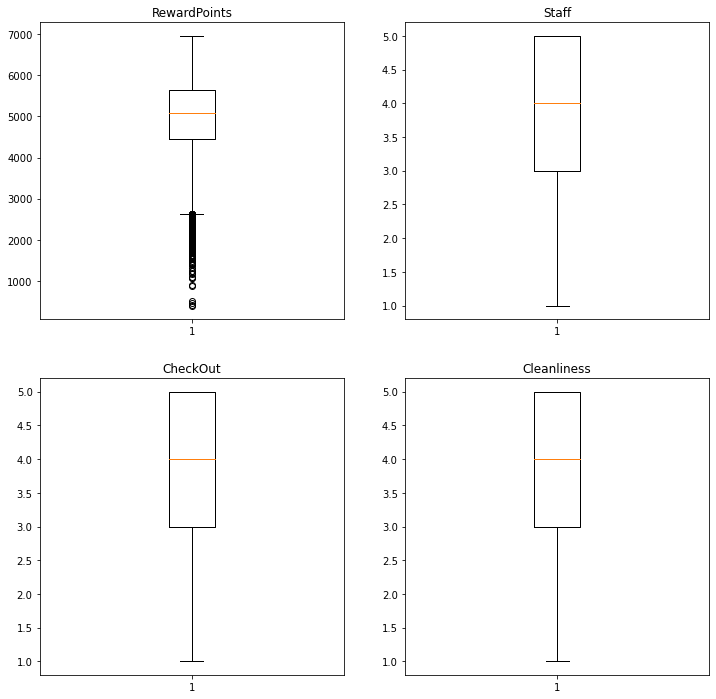

In [8]:
fig, axs = plt.subplots(2, 2, figsize = (12,12))

axs[0, 0].boxplot(data = data, x = 'RewardPoints')
axs[0, 0].set_title('RewardPoints')
axs[0, 1].boxplot(data = data, x = 'Staff')
axs[0, 1].set_title('Staff')
axs[1, 0].boxplot(data = data, x = 'CheckOut')
axs[1, 0].set_title('CheckOut')
axs[1, 1].boxplot(data = data, x = 'Cleanliness')
axs[1, 1].set_title('Cleanliness')

<AxesSubplot:xlabel='RewardPoints', ylabel='Count'>

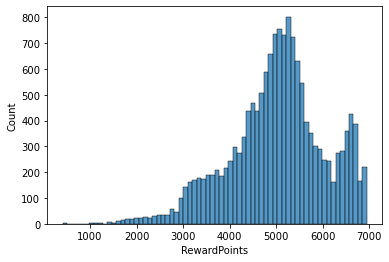

In [9]:
sns.histplot(data = data, x = 'RewardPoints')

-----
## Faz Sentido: NÃO FAZ
##### Tranformação logaritmica ou de raiz quadrada apenas deve sre feita para variáveis com skewness direita. Neste caso, poderiamos utilizar transformação quadrática ou cúbica, mas uma vez que a skewness não é acentoada, não há necessidade
In order to understand if a transformations should be made regarding the variables with highest skewness in order to normalize them.

As it can be seen, both log and sqrt transformations would only increase the skewness of the variables

In [10]:
# print('Skewness\n\nCleanliness:\n','Normal: ',data['Cleanliness'].skew(),'\n'\
#       ' Log: ',np.log(data['Cleanliness']).skew(),'\n'\
#       ' sqrt: ',np.sqrt(data['Cleanliness']).skew(),'\n'\
#       '\nCheckOut:\n','Normal: ',data['CheckOut'].skew(),'\n'\
#       ' Log: ',np.log(data['CheckOut']).skew(),'\n'\
#       ' sqrt: ',np.sqrt(data['CheckOut']).skew(),'\n'\
#       '\nStaff:\n','Normal: ',data['Staff'].skew(),'\n'\
#       ' Log: ',np.log(data['Staff']).skew(),'\n'\
#       ' sqrt: ',np.sqrt(data['Staff']).skew(),'\n'\
#      )

Regarding the possible issue of having customers under the age of 18 years, we proceeded to understand how many are these. They represent 1051 customers on our database.

In fact, it might be possible to travel solo having less than 18 years. Instead, these customers can be accompanying other adults. Perhaps they should not be disregarded from our analysis.

In [11]:
len(data.query("Year_Birth > 2004"))

1051

We also took a general look on the spearman correlations between the numerical variables, even though we know some corrections to data might be performed later.

We observe that Comfort and FoodDrink have a high positive correlation of 0.7, as well as the variable pairs Staff and BarService, and OnlineBooking and BarService. We also can identify some "blocks" of variables that jointly appear to be correlated. We will address these findings later.

<AxesSubplot:>

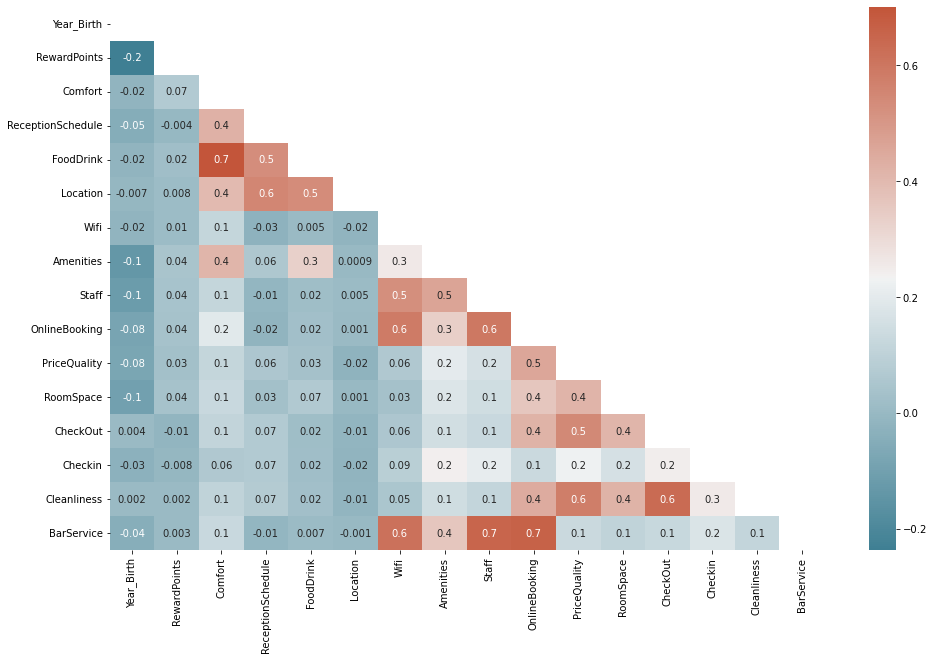

In [12]:
data_corr = data.corr(method = 'spearman')
matrix = np.triu(data_corr)
# annot_labels = np.empty_like(data_corr, dtype=str)
# annot_mask = data_corr > 0.6
# annot_labels[annot_mask] = 'True'
figure = plt.figure(figsize=(16,10))
sns.heatmap(data_corr, annot=True, cmap = sns.diverging_palette(220, 20, as_cmap=True),  fmt = '.1g', mask = matrix)

Given our findings by looking at the correlation matrix above, the creation of three buckets of variables according to the correlations between the 14 satisfaction variables could help. There buckets would be divided as follows:

1. Rating1 includes variables Comfort, ReceptionSchedule, FoodDrink and Location.
2. Rating2 includes variables Amenities, Wifi, OnlineBooking, Staff and BarService.
3. Rating3 includes variables PriceQuality, RoomSpace, CheckOut, Checkin and Cleanliness.


We now move forward to explore our categorical variables. Using the methods _describe_ and _value_counts_ we can dive deeper on the exploration of these variables.

Some interesting findings are summarized below:
1. Most of our customers are "old" customers that use our services for more than a year. We are not seeming to catch new customers.
2. Most of the customers on our dataset travel by business.
3. Few customers book suite rooms.
4. There isn't any categorical variable that's Univariate.

In [13]:
data.describe(include="O").T

,count,unique,top,freq
Name,15589,14227,Mr. Michael Smith,9
Longevity,15589,3,yes,12548
TypeTravel,15589,2,business,10756
RoomType,15589,3,single,7442


In [14]:
print('--> Longevity:\n',db['Longevity'].value_counts(),'\n')
print('--> TypeTravel:\n',db['TypeTravel'].value_counts(),'\n')
print('--> RoomType:\n',db['RoomType'].value_counts())

--> Longevity:
 yes    12548
no      2874
y        167
Name: Longevity, dtype: int64 

--> TypeTravel:
 business    10756
leisure      4833
Name: TypeTravel, dtype: int64 

--> RoomType:
 single    7442
double    7021
suite     1126
Name: RoomType, dtype: int64


##### Type Travel vs RoomType

<AxesSubplot:xlabel='count', ylabel='TypeTravel'>

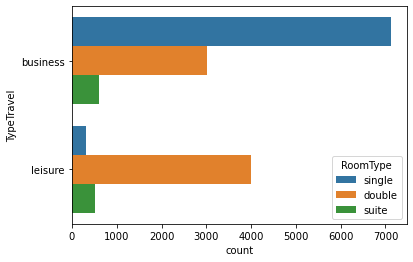

In [15]:
sns.countplot(y = 'TypeTravel', hue = 'RoomType', data = db,
             order = ['business','leisure'])

##### Type Travel vs Longevity

<AxesSubplot:xlabel='count', ylabel='TypeTravel'>

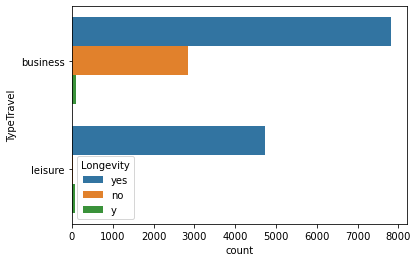

In [16]:
sns.countplot(y = 'TypeTravel', hue = 'Longevity', data = db,
             order = ['business','leisure'])

Before moving forward to some more data cleaning, we wanted to verify if there are recurrent visits from the same customers on our dataset. We checked that there are repeated visits from customers with the same name and year of birth in our dataset.

At this point, our analysis leads us to assume that these might be the same customers. The number of reward points changes according to each visit.
- 39 clients have the same name and year of birth, meaning that they might be recurrent visits.
- 26 of those clients have the same Longevity status, meaning that enough time has passed on 13 clients to change the Longevity status from 0 to 1.
- 13 of those clients have kept the same RoomType and Longevity. They can potentially be the same people.
- No client has the same amount of RewardPoints, meaning that they change according to the number of visits.
- On average, RewardPoints varies 697 points [from 30 to 1892] or 165 [from -645 to 1892]

In [17]:
#Recurrent Visits - exploration
#This is aimed at getting more insight about recurrent visits and how they would affect RewardPoints

recur1 =  pd.DataFrame(db.groupby(['Name', 'Year_Birth'])['Name'].count())
recur1.rename(columns = {'Name':'Recurrent'}, inplace = True)
recur1.query("Recurrent >= 2", inplace = True) #'Number_of_Visits >= 2'
recur1

#39 clients have the same name and year of birth, meaning that they might be recurrent visits.

recur2 =  pd.DataFrame(db.groupby(['Name', 'Year_Birth', 'Longevity'])['Name'].count())
recur2.rename(columns = {'Name':'Recurrent'}, inplace = True)
recur2.query("Recurrent >= 2", inplace = True) #'Number_of_Visits >= 2'
recur2

#26 of those clients have the same Longevity status, meaning that enough time has passed on 13 clients to change the Longevity status from 0 to 1.

recur3 =  pd.DataFrame(db.groupby(['Name', 'Year_Birth', 'Longevity', 'RoomType'])['Name'].count())
recur3.rename(columns = {'Name':'Recurrent'}, inplace = True)
recur3.query("Recurrent >= 2", inplace = True) #'Number_of_Visits >= 2'
recur3

#13 of those clients have kept the same RoomType and Longevity. They can potentially be the same people.

recur4 =  pd.DataFrame(db.groupby(['Name', 'Year_Birth', 'Longevity', 'RoomType', 'RewardPoints'])['Name'].count())
recur4.rename(columns = {'Name':'Recurrent'}, inplace = True)
recur4.query("Recurrent >= 2", inplace = True) #'Number_of_Visits >= 2'
recur4

#No client has the same amount of RewardPoints, meaning that they change according to the number of visits.
#On average, RewardPoints varies 697 points [from 30 to 1892] or 165 [from -645 to 1892]

#db.loc[db.Name == "Ms. Danielle Taylor"]
#For Anthony Smith (1982) - 4508/5275/5554, Business Single and Suite
#For Brian Smith (1979) - 4478/4567, Business Single
#For Christopher Murphy (1979) - 6367/6152, Business Single
#For Jason Bell (1996) - 4539/3404, Business Single
#For John Russel (1977) - 3645/4013, Business Single
#For John Schwartz (1980) - 5607/5577, Business Double
#For Joseph Thomas (1970) - 5051/6570, Business Single
#For Michael Miller (1992) - 3907/4442, Business Single
#For Timothy Lee (1980) - 5113/3221, Business Single - Churn
#For Amanda Smith (1962) - 6190/3906, Business Double - Churn and Business Single
#For Amanda Smith (1969) - 6577/6655, Business Single
#For Cynthia Martin (1991) 4939/4456, Business Single - Churn
#For Dana Anderson (1972) 5807/6452, Business Double
#For Danielle Taylor (1981) 5147/4990, Business Double

,,,,,Recurrent
Name,Year_Birth,Longevity,RoomType,RewardPoints,
Ms. Abigail Buchanan,1972.0,yes,double,6769,2
Ms. Abigail Kennedy,1991.0,yes,suite,5932,2
Ms. Abigail York,1995.0,yes,double,5098,2


##### Replace incorrect performance values

In [18]:
print((data.loc[:, 'Comfort':] == 0).sum().sum())
print((data.loc[:, 'Comfort':] == 1).sum().sum())
print((data.loc[:, 'Comfort':] == 2).sum().sum())
print((data.loc[:, 'Comfort':] == 3).sum().sum())
print((data.loc[:, 'Comfort':] == 4).sum().sum())
print((data.loc[:, 'Comfort':] == 5).sum().sum())
print((data.loc[:, 'Comfort':] == 6).sum().sum())

2525
25447
34395
45349
62009
48485
36


About valuation of Customer Satisfaction
- 0.01% of valuation 6 --> To remove the 6
- 1.2% of valuation 0 --> seams legit. Keep the 0

##### Transformations to be made
- Remove 6 from Wifi Valuations
- Create bins from Reward Points changing from numerical to categorical
- Create variable 'Gender' from the name variable & Drop 'Name' variable
- Transform all 'y' to 'yes' in Longevity
- Year of birth using KNN Imputer
- Create 3 buckets of variables
- Convert datatypes

##### Transformations to be made onle after separating training from validation

- Remove valuation 6 from Wifi variable

In [19]:
data['Wifi'] = data['Wifi'].replace(6,5)

----
- Change RewardPoints from Numerical to Categorical

In [20]:
data['RewardPoints_Bins'] = pd.cut(data['RewardPoints'], 4, labels=['Bronze', 'Silver', 'Gold', 'Platinum'])
# data['RewardPoints_Bins'] = data['RewardPoints_Bins'].replace('Bronze',0).replace('Silver',1).replace('Gold',2).replace('Platinum',3)
data.drop(columns = ['RewardPoints'], axis=1, inplace=True)

----
- Change Name to Gender

In [21]:
gender = data['Name'].str.split(' ',expand = True,n=1)[0]
data['Gender'] = gender
data['Gender'] = data['Gender'].replace('Ms.','F').replace('Mr.','M')
data.drop(columns = ['Name'], axis = 1, inplace = True)

----
- Correct 'y' to 'yes' in Longevity variable

In [22]:
data['Longevity'] = data['Longevity'].replace('y','yes')

----
- Year of Birth variable: correct NA values in 

We notice the missing values in the Year_Birth column are of type MAR (Missing At Random). In fact, 81.5% of the customers with this column missing are women.

The KNN Imputer algorythm was used to compare the results with other ways of replacing the missing data (mean, median and mode).
Running the algorythm shows that both the mean, median and mode of the overall data don't change much, having a slight change on the mean from 1981.7064 to 1981.6958, and maintaining the median in 1981 and mode in 1982.

However, when we check only the indexes that had missing values, we see that their mean is 1983.1384 (year and a half higher than the overall), the median is 1983 (2 years higher) and the mode 1977 (5 years lower).

Since the overall values didn't change much, it seams preferable to replace the missing values with the KNN Imputer algorithm since it's is sensible to the rest of the data and no only to the variables in question.

We decided to use the default values of this imputer provided by sklearn, then considering 125 neighbors (square root of the length of the data), euclidean distance, and uniform weights for all neighbors.


In [23]:
print('Year of Birth:\n\nMean: ',db['Year_Birth'].mean(),\
      '\nMedian: ',db['Year_Birth'].median(),\
      '\nMode:',db['Year_Birth'].mode(),)

Year of Birth:

Mean:  1981.7064440691179 
Median:  1981.0 
Mode: 0    1982.0
Name: Year_Birth, dtype: float64


In [24]:
from sklearn.impute import KNNImputer
num_var = data.select_dtypes(include=np.number).set_index(data.index).columns
list_na_year = data[data['Year_Birth'].isna()].index.tolist()
k_imputer = round(np.sqrt(len(data[num_var])),0).astype('int32') # 125
imputer = KNNImputer(n_neighbors=k_imputer, weights="uniform", metric='nan_euclidean')
imputer.fit(data[num_var])
data_KNN = imputer.transform(data[num_var])
data_KNN = pd.DataFrame(data_KNN)
data_KNN[0] = data_KNN[0].round(0)
data_KNN[0].count
print('Year of Birth Specific previews NA Values:\n\nMean: ',data_KNN[0][list_na_year].mean(),\
      '\nMedian: ',data_KNN[0][list_na_year].median(),\
      '\nMode:',data_KNN[0][list_na_year].mode(),'\n')
print('Year of Birth Overall Values:\n\nMean: ',data_KNN[0].mean(),\
      '\nMedian: ',data_KNN[0].median(),\
      '\nMode:',data_KNN[0].mode(),)

Year of Birth Specific previews NA Values:

Mean:  1983.1692307692308 
Median:  1983.0 
Mode: 0    1977.0
1    1981.0
2    1984.0
3    1994.0
4    1997.0
Name: 0, dtype: float64 

Year of Birth Overall Values:

Mean:  1981.692860350247 
Median:  1981.0 
Mode: 0    1982.0
Name: 0, dtype: float64


-> Only to be made after seperation of train and validation

----
- Creation of Buckets

In [25]:
data['Rating1'] = round((data['Comfort'] + data['ReceptionSchedule'] + data['FoodDrink'] + data['Location'])/4,2)
data['Rating2'] = round((data['Amenities'] + data['Wifi'] + data['OnlineBooking'] + data['Staff']+ data['BarService'])/5,2)
data['Rating3'] = round((data['PriceQuality'] + data['RoomSpace'] + data['CheckOut']+ data['Checkin']+ data['Cleanliness'])/5,2)

----
- Scale the numerical data

-> Only to be made after seperation of train and validation

----
- Separate Numerical from Categorical Data

In [26]:
num_var = data.select_dtypes(include=np.number).set_index(data.index).columns
cat_var = data.select_dtypes(exclude=np.number).set_index(data.index).columns
print(num_var)
print(cat_var)

Index(['Year_Birth', 'Comfort', 'ReceptionSchedule', 'FoodDrink', 'Location',
       'Wifi', 'Amenities', 'Staff', 'OnlineBooking', 'PriceQuality',
       'RoomSpace', 'CheckOut', 'Checkin', 'Cleanliness', 'BarService',
       'Rating1', 'Rating2', 'Rating3'],
      dtype='object')
Index(['Longevity', 'TypeTravel', 'RoomType', 'RewardPoints_Bins', 'Gender'], dtype='object')


----
- Change DataTypes

-> Only to be made after scaling the data

----
- Create numerical variable list without the buckets to compare

In [27]:
num_var_nbuckes = num_var[:-3]

----
# Feature Selection

### Weight of the dependent variable in categorical data

- From the Spearman Correlation, the variable Amenities shows a relation greater then 0,5.
- Also, Rating 2 (composed by Amenities, Wifi, Online Booking, Staff and Bar Service) shows a correlation of 0,5

<AxesSubplot:>

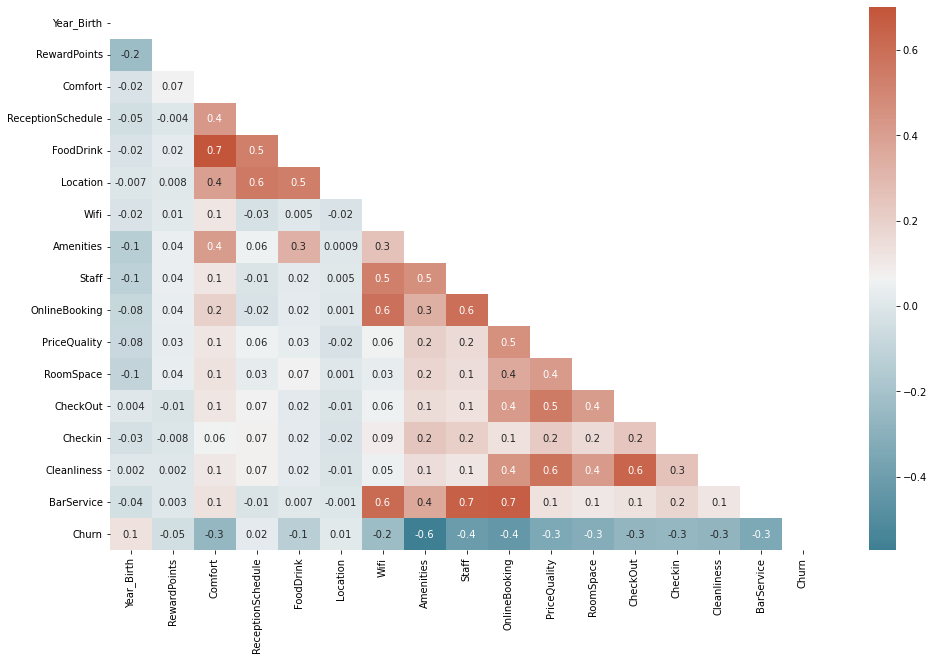

In [12]:
all_data_cor = data.join(target)
all_data_cor['Churn'] = all_data_cor['Churn'].replace('nochurn',0).replace('churn',1)
data_corr = all_data_cor.corr(method = 'spearman')
matrix = np.triu(data_corr)
figure = plt.figure(figsize=(16,10))
sns.heatmap(data_corr, annot=True, cmap = sns.diverging_palette(220, 20, as_cmap=True), fmt = '.1g', mask = matrix)

----
From the graphical analysis between the dependent variable and the categorical variables, the following outputs can be taken:
- A non-longevity client is more likely to churn, but these clients are the minority of our dataset on a proportion of 1/4 to 3/4
- Business clients are less likelly to churn and also the majority on a proportion of 2/3 to 1/3
- Single room clients are less likely to churn, being of the same amount as double room clients
- There seams to be no great relevance of the Rewards points on the dependent variable
- Lastly, male clients are more likely to churn than female clients, being their proportion similar

In [29]:
def frequency_charts_categorical(df, feature, target):
    fig = plt.figure(figsize=(20, 5))
    subplots=[151,152,153,154,155]
    
    for i in range(len(feature)):
        cont_tab = pd.crosstab(df[feature[i]], df[target], margins = True)
        #print(cont_tab)
        categories = cont_tab.index[:-1]
        #print(cont_tab.iloc[:-1, 0])
        plt.subplot(subplots[i])
        p1 = plt.bar(categories, cont_tab.iloc[:-1, 0].values, 0.55, color="gray") # Churn
        p2 = plt.bar(categories, cont_tab.iloc[:-1, 1].values, 0.55, bottom=cont_tab.iloc[:-1, 0], color="#EC7063")
        plt.legend((p2[0], p1[0]), ('$y_i=0$', '$y_i=1$'))
        plt.title("Frequency bar chart")
        plt.xlabel(feature)
        plt.ylabel("$Frequency$")

    plt.show()

def proportion_charts_categorical(df, feature, target):
    fig = plt.figure(figsize=(20, 5))
    subplots=[151,152,153,154,155]
    
    for i in range(len(feature)):
        cont_tab = pd.crosstab(df[feature[i]], df[target], margins = True)
        categories = cont_tab.index[:-1]
        obs_pct = np.array([np.divide(cont_tab.iloc[:-1, 0].values, cont_tab.iloc[:-1, 2].values), 
                            np.divide(cont_tab.iloc[:-1, 1].values, cont_tab.iloc[:-1, 2].values)])
        plt.subplot(subplots[i])
        p1 = plt.bar(categories, obs_pct[0], 0.55, color="gray")
        p2 = plt.bar(categories, obs_pct[1], 0.55, bottom=obs_pct[0], color="#AED6F1")
        plt.legend((p2[0], p1[0]), ('$y_i=0$', '$y_i=1$'))
        plt.title("Proportion bar chart")
        plt.xlabel(feature)
        plt.ylabel("$Proportion$")

    plt.show()

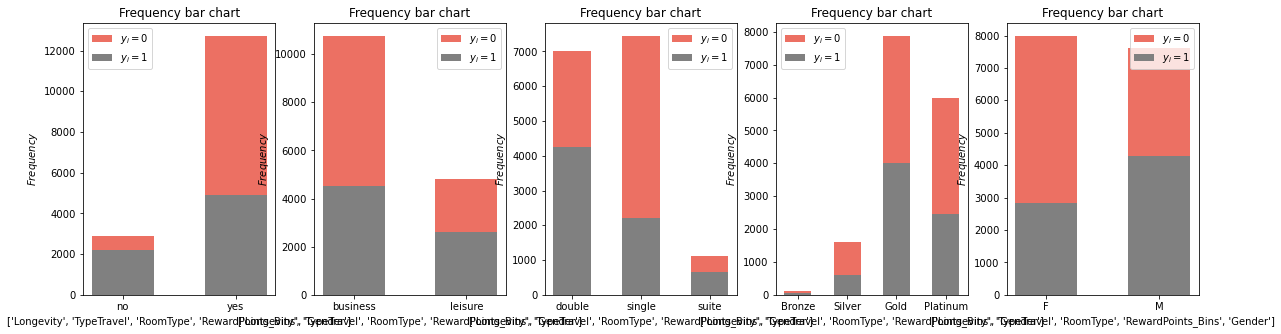

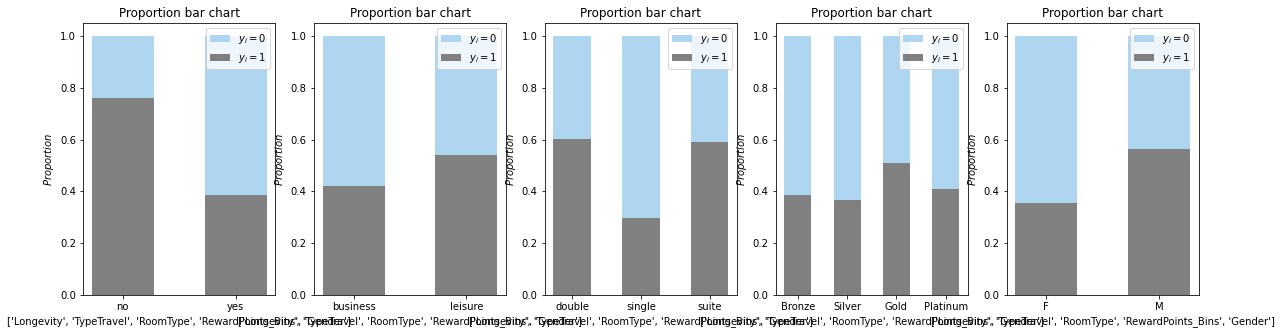

In [30]:
frequency_charts_categorical(data.join(target), ['Longevity','TypeTravel','RoomType','RewardPoints_Bins','Gender'], "Churn")
proportion_charts_categorical(data.join(target), ['Longevity','TypeTravel','RoomType','RewardPoints_Bins','Gender'], "Churn")

----
##### Rating 1 variables

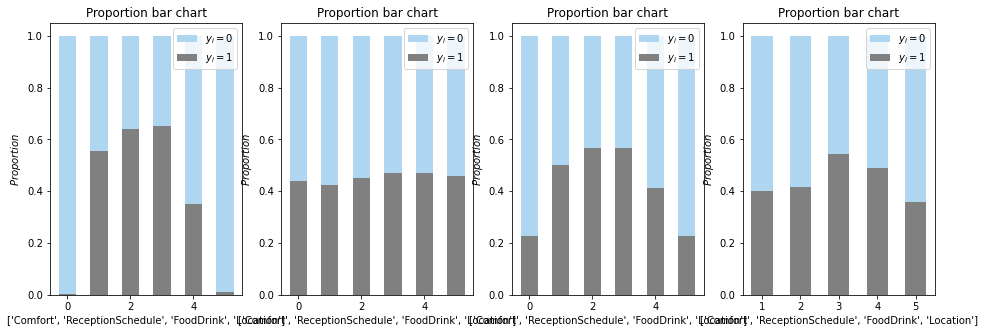

In [31]:
proportion_charts_categorical(data.join(target), ['Comfort','ReceptionSchedule','FoodDrink','Location'], "Churn")

----
##### Rating 2 variables

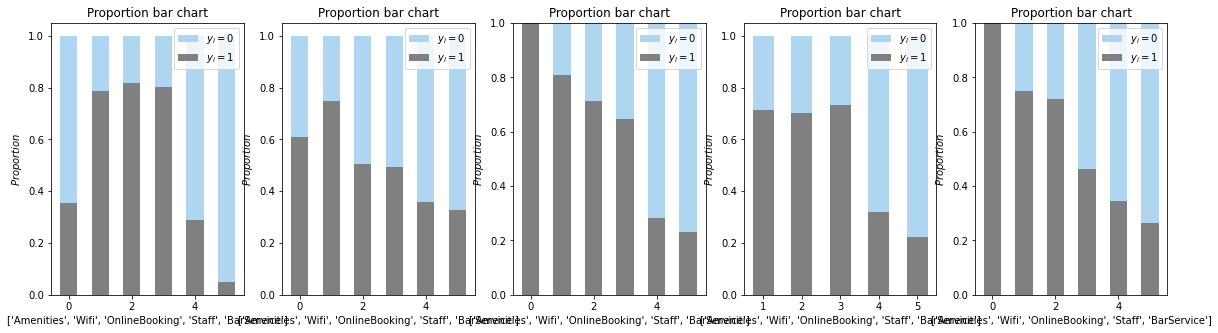

In [32]:
proportion_charts_categorical(data.join(target), ['Amenities','Wifi','OnlineBooking','Staff','BarService'], "Churn")

----
##### Rating 3 variables

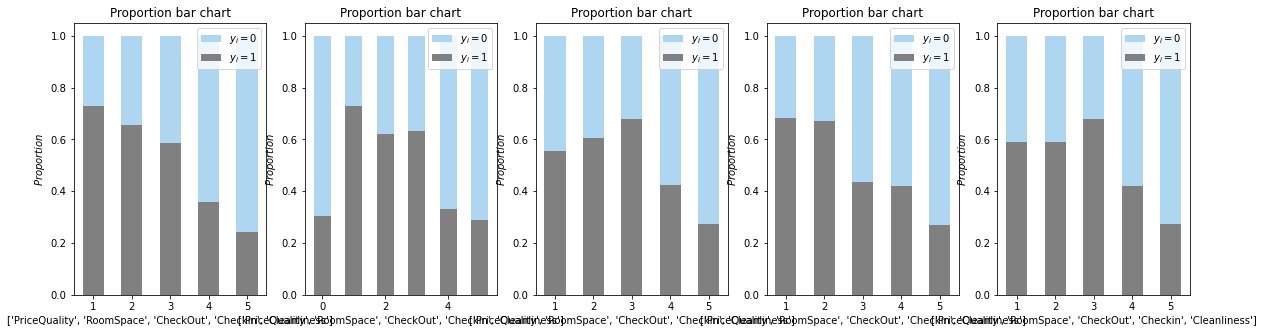

In [33]:
proportion_charts_categorical(data.join(target), ['PriceQuality','RoomSpace','CheckOut','Checkin','Cleanliness'], "Churn")

Text(0, 0.5, '$Proportion$')

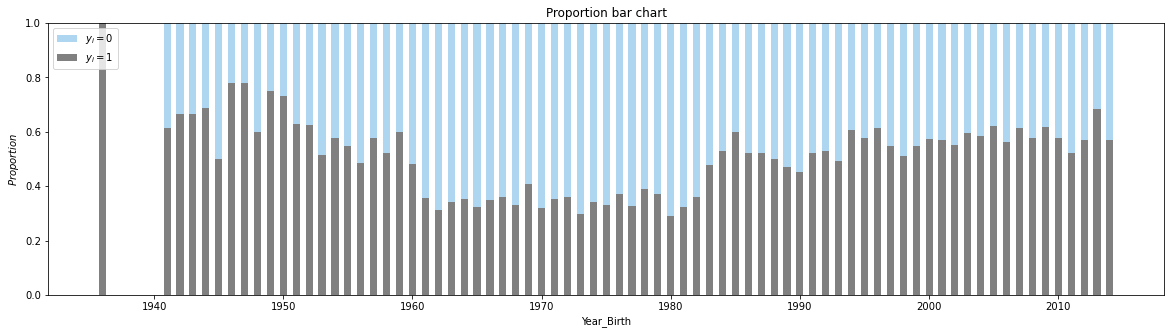

In [34]:
df=data.join(target)
fig = plt.figure(figsize=(20, 5))
cont_tab = pd.crosstab(df['Year_Birth'], df['Churn'], margins = True)
#print(cont_tab)
categories = cont_tab.index[:-1]
obs_pct = np.array([np.divide(cont_tab.iloc[:-1, 0].values, cont_tab.iloc[:-1, 2].values), 
                    np.divide(cont_tab.iloc[:-1, 1].values, cont_tab.iloc[:-1, 2].values)])
p1 = plt.bar(categories, obs_pct[0], 0.55, color="gray")
p2 = plt.bar(categories, obs_pct[1], 0.55, bottom=obs_pct[0], color="#AED6F1")
plt.legend((p2[0], p1[0]), ('$y_i=0$', '$y_i=1$'))
plt.title("Proportion bar chart")
plt.xlabel('Year_Birth')
plt.ylabel("$Proportion$")

In [35]:
from sklearn.cluster import KMeans

----
In order to help us select the variables to use in the model, we'll apply a Stratified K-Fold with different models, mainly:
- For Numerical Variables:
    - Logistic Regression
    - Decision Tree
    - Random Forest
- For Categorical Variables:
    - Chi-Square

In [36]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LassoCV
from sklearn.svm import SVC

In [37]:
def select_best_features(X, y, splits):
    sel_log = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    sel_tree = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    sel_forest = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    sel_lasso = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    sel_svc = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    skf = StratifiedKFold(n_splits =  splits)
    counter = 0
    for train_index, val_index in skf.split(X, y):
        counter +=1
        print('')
        print('--------------------------------------------------------')
        print('SPLIT ', counter)
        print('--------------------------------------------------------')
        print('')
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        # get all numerical variables
        X_train_num = X_train[num_var]
        X_val_num = X_val[num_var]
        
        # get all categorical variables
        X_train_cat = X_train[cat_var]
        X_val_cat = X_val[cat_var]
        
        # fill missing values (KNN Imputer for Year of Birth: first variable of numerical variables)
        k_imputer = round(np.sqrt(len(X_train_num)),0).astype('int32') # 125
        imputer = KNNImputer(n_neighbors=k_imputer, weights="uniform", metric='nan_euclidean')
        imputer.fit(X_train_num)
        data_KNN_train = imputer.transform(X_train_num)
        data_KNN_train = pd.DataFrame(data_KNN_train)
        data_KNN_train[0] = data_KNN_train[0].round(0)
        X_train_num['Year_Birth'] = data_KNN_train[0].values
        # Use Train Imputer for Validation Data
        data_KNN_val = imputer.transform(X_val_num)
        data_KNN_val = pd.DataFrame(data_KNN_val)
        data_KNN_val[0] = data_KNN_val[0].round(0)
        X_val_num['Year_Birth'] = data_KNN_val[0].values
        
        # Apply scaling to numerical data
        scaler = MinMaxScaler().fit(X_train_num)
        X_train_scaled = pd.DataFrame(scaler.transform(X_train_num), columns = X_train_num.columns, index = X_train_num.index,) # MinMaxScaler in the training data
        X_val_scaled = pd.DataFrame(scaler.transform(X_val_num), columns = X_val_num.columns, index = X_val_num.index,) # MinMaxScaler in the validation data
        
        # Check which features to use using RFE and logistic regression
        model = LogisticRegression()
        rfe = RFE(estimator = model, n_features_to_select = 5)
        X_rfe = rfe.fit_transform(X = X_train_scaled, y = y_train)
        selected_features = pd.Series(rfe.support_, index = X_train_scaled.columns)
        sel_log=np.add(sel_log,list(map(int, selected_features)))
        
        # Check which features to use using RFE and decision tree
        model = DecisionTreeClassifier()
        rfe = RFE(estimator = model, n_features_to_select = 5)
        X_rfe = rfe.fit_transform(X = X_train_scaled, y = y_train)
        selected_features = pd.Series(rfe.support_, index = X_train_scaled.columns)
        sel_tree=np.add(sel_tree,list(map(int, selected_features)))
        
        # Check which features to use using RFE and random forest
        model = RandomForestClassifier()
        rfe = RFE(estimator = model, n_features_to_select = 5)
        X_rfe = rfe.fit_transform(X = X_train_scaled, y = y_train)
        selected_features = pd.Series(rfe.support_, index = X_train_scaled.columns)
        sel_forest=np.add(sel_forest,list(map(int, selected_features)))
        
        # Check which features to use using RFE and SVC
        model = SVC(kernel="linear")
        rfe = RFE(estimator = model, n_features_to_select = 5)
        X_rfe = rfe.fit_transform(X = X_train_scaled, y = y_train)
        selected_features = pd.Series(rfe.support_, index = X_train_scaled.columns)
        sel_svc=np.add(sel_svc,list(map(int, selected_features)))

        #Lasso
        reg = LassoCV()
        reg.fit(X=X_train_scaled, y=y_train.replace('nochurn',0).replace('churn',1))
        print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
        print("Best score using built-in LassoCV: %f" %reg.score(X = X_train_scaled,y = y_train.replace('nochurn',0).replace('churn',1)))
        coef = pd.Series(reg.coef_, index = X_train_scaled.columns)
        sel_lasso=np.add(sel_lasso,coef.values)
        
        # Check which features to use using Chi-Square
        print('')
        print('----------------- CHI-SQUARE ----------------------')
        def TestIndependence(X,y,var,alpha=0.05):        
            dfObserved = pd.crosstab(y,X) 
            chi2, p, dof, expected = chi2_contingency(dfObserved.values)
            dfExpected = pd.DataFrame(expected, columns=dfObserved.columns, index = dfObserved.index)
            if p<alpha:
                result="{0} is IMPORTANT for Prediction".format(var)
            else:
                result="{0} is NOT important for Prediction. (Discard {0} from model)".format(var)
            print(result)
        
        for var in X_train_cat:
            TestIndependence(X_train_cat[var],y_train, var)
    
    sel_lasso = sel_lasso/splits
            
#     final = pd.DataFrame(np.array([sel_log,sel_tree,sel_lasso.round(2)]),\
#                          columns=num_var,index=['Logistic Regression','Decision Tree','Lasso'])
            
    final = pd.DataFrame(np.array([sel_log,sel_tree,sel_forest,sel_lasso,sel_svc]),\
                         columns=num_var,index=['Logistic Regression','Decision Tree',\
                                                'Random Forest','Lasso','SVC'])
            
    print(final.T)
    

In [38]:
select_best_features(data, target, 5)


--------------------------------------------------------
SPLIT  1
--------------------------------------------------------



KeyboardInterrupt: 

| Predictor | RFE Logistic | RFE Decision Tree | RFE Random Forest | Lasso | SVC | Correlation | Include in the model?
| --- | --- | --- | --- |--- | --- | --- | --- |
| Year_Birth | Discard | Keep | Keep? | Keep? | Discard | Discard |  Keep?
| Comfort | Discard | Keep | Keep | Keep | Discard | Discard | Keep
| ReceptionSchedule | Discard | Discard | Discard | Keep | Discard | Discard | Discard
| FoodDrink | Discard | Discard | Discard | Discard | Discard | Keep |Discard 
| Location | Discard | Discard | Discard | Discard | Discard | Keep? | Discard
| Wifi | Keep | Discard | Discard | Keep? | Keep? | Discard | Keep?
| Amenities | Keep | Keep | Keep | Keep | Keep | Keep | Keep
| Staff | Discard | Discard | Discard | Keep | Discard | Keep? | Keep?
| OnlineBooking | Discard | Discard | Discard | Keep | Keep? | Keep? | Keep?
| PriceQuality | Keep | Discard | Discard | Keep | Keep | Discard | Discard
| RoomSpace | Keep | Discard | Discard | Keep | Keep | Discard | Keep?
| CheckOut | Discard | Discard | Discard | Discard | Discard | Discard | Discard
| CheckIn | Discard | Discard | Discard | Keep? | Discard | Discard | Discard
| Cleanliness | Discard | Discard | Discard | Keep? | Discard | Discard | Discard
| BarService | Discard | Discard | Discard | Discard | Discard | Discard | Discard
| Rating1 | Discard | Keep? | Keep? | Discard | Discard | Discard | Discard
| Rating2 | Keep | Keep | Keep | Discard | Keep | Keep | Keep?
| Rating3 | Discard | Keep | Keep | Discard | Discard | Keep? | Keep?


#### Numerical variables to keep
- Comfort
- Amenities
- Rating3 / PriceQuality and RoomSpace
- Year_Birth

- Rating2 will be discarded since it is clearly influenced by the Amenities variable
----
#### Categorical variables to keep
From the Chi-Square, every single variable was marked as important
however, from the weighting of the dependant variable, the variable RewardPoints won't be used

----
# Models

In [39]:
def compare_models(X, y, model, splits):
    # apply StratifiedK-Fold
    skf = StratifiedKFold(n_splits = splits)
    score_train = []
    score_val = []
    for train_index, val_index in skf.split(X, y):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        y_train = y_train.replace('nochurn',0).replace('churn',1)
        y_val = y_val.replace('nochurn',0).replace('churn',1)
        
        catvars = X_train.select_dtypes(exclude=np.number).set_index(X_train.index).columns
        # This time we are going to use validation to check overfitting 
        # so we need also to make all the needed changes in the validation
        
        # WITH MODE
        if 'Year_Birth' in X_train.columns:
            mode_year_train = X_train['Year_Birth'].mode()[0]
            X_train['Year_Birth'].fillna(mode_year_train, inplace = True)
            X_val['Year_Birth'].fillna(mode_year_train, inplace = True)
        
        # fill missing values (KNN Imputer for Year of Birth: first variable of numerical variables)
#         k_imputer = round(np.sqrt(len(X_train[selected_num])),0).astype('int32') # 125
#         imputer = KNNImputer(n_neighbors=k_imputer, weights="uniform", metric='nan_euclidean')
#         imputer.fit(X_train[selected_num])
#         data_KNN_train = imputer.transform(X_train[selected_num])
#         data_KNN_train = pd.DataFrame(data_KNN_train)
#         data_KNN_train[0] = data_KNN_train[0].round(0)
#         X_train['Year_Birth'] = data_KNN_train[0].values
#         # Use Train Imputer for Validation Data
#         data_KNN_val = imputer.transform(X_val[selected_num])
#         data_KNN_val = pd.DataFrame(data_KNN_val)
#         data_KNN_val[0] = data_KNN_val[0].round(0)
#         X_val['Year_Birth'] = data_KNN_val[0].values
        
        # Create dummies and remove one of the variables (to avoid multicollinearity)
        X_train_dummies = pd.get_dummies(X_train, columns=catvars, drop_first=True)
        X_val_dummies = pd.get_dummies(X_val, columns=catvars, drop_first=True)
        
        # If we don't have all the values in the validation dataset that we have in the train, that column will not be created
        # We should assure that all columns in train are also present in validation
        # Get missing columns from the training dataset
        missing_cols = set(X_train_dummies.columns ) - set(X_val_dummies.columns )
        # Add a missing column in test set with default value equal to 0
        for c in missing_cols:
            X_val_dummies[c] = 0
        # Ensure the order of column in the test set is in the same order than in train set
        X_val_dummies = X_val_dummies[X_train_dummies.columns]
        
        # Apply scaling to numerical data
        scaler = MinMaxScaler().fit(X_train_dummies)
        X_train_scaled = pd.DataFrame(scaler.transform(X_train_dummies), columns = X_train_dummies.columns, index = X_train_dummies.index,) # MinMaxScaler in the training data
        X_val_scaled = pd.DataFrame(scaler.transform(X_val_dummies), columns = X_val_dummies.columns, index = X_val_dummies.index,) # MinMaxScaler in the validation data

        # Apply model
        model.fit(X_train_scaled, y_train)
        predictions_train = model.predict(X_train_scaled)
        predictions_val = model.predict(X_val_scaled)
        score_train.append(f1_score(y_train, predictions_train))
        score_val.append(f1_score(y_val, predictions_val))

    avg_train = round(np.mean(score_train),3)
    avg_val = round(np.mean(score_val),3)
    std_train = round(np.std(score_train),2)
    std_val = round(np.std(score_val),2)

    return str(avg_train) + '+/-' + str(std_train),str(avg_val) + '+/-' + str(std_val)

In [40]:
def show_results(df, X, y, *args):
    """
    Receive an empty dataframe and the different models and call the function avg_score
    """
    count = 0
    # for each model passed as argument
    for arg in args:
        # obtain the results provided by avg_score
        avg_train, avg_test = compare_models(X, y, arg, 10)
        # store the results in the right row
        df.iloc[count] = avg_train, avg_test
        count+=1
    
    return df

In [41]:
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier

##### We tried imputing the missing values with both KNN-Imputer, Median and Mode reaching less overfitting and similar results using the mode or median

- Using Year_Birth or Rating2 Increases the overfitting
- Rating3 increases the train and val scores
- Both amenities and Confort greatly increase the scores
- Using PriceQuality and RoomSpace instead of Rating3 decreases the scores in all models, except RandomForest

----
##### Preparing data for model testing

In [42]:
data_sel = data[['Longevity','TypeTravel','RoomType','Gender']+\
                ['Comfort','Location', 'Amenities', 'Staff', 'OnlineBooking','PriceQuality']].copy()
#Need to try with PriceQuality and RoomSpace instead of Rating3
catvars = data_sel.select_dtypes(exclude=np.number).set_index(data_sel.index).columns
# Create dummies and remove one of the variables (to avoid multicollinearity)
data_final_dummies = pd.get_dummies(data_sel, columns=catvars, drop_first=True)
# Data Scaling
# Apply MinMaxScaler
scaler = MinMaxScaler().fit(data_final_dummies)
data_final_scaled = scaler.transform(data_final_dummies)

pd.DataFrame(data_final_scaled).iloc[:,(pd.DataFrame(data_final_scaled).dtypes=='int64').values] = \
pd.DataFrame(data_final_scaled).iloc[:,(pd.DataFrame(data_final_scaled).dtypes=='int64').values].astype(np.int8)

----
##### Grid Search for Decision Tree

In [47]:
from sklearn.model_selection import GridSearchCV

In [43]:
parameter_space = {
    'criterion': ['gini','entropy','log_loss'],
    'splitter':['best','random'],
    'min_samples_split':[2,3,4,5],
    'min_samples_leaf':[1,2,3],
    'max_features': ['auto','sqrt','log2'],
}

In [44]:
model = DecisionTreeClassifier()

In [45]:
clf_dt = GridSearchCV(model, parameter_space)

In [46]:
clf_dt.fit(data_final_scaled, target)

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4, 5],
                         'splitter': ['best', 'random']})

In [47]:
clf_dt.best_params_

{'criterion': 'entropy',
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'splitter': 'best'}

##### Best for:

[['Longevity','TypeTravel','RoomType','Gender']+['Comfort','Amenities','Rating3']]

{'criterion': 'entropy',
 'max_features': 'log2',
 'min_samples_leaf': 3,
 'min_samples_split': 3,
 'splitter': 'best'}
 
 DecisionTreeClassifier(criterion= 'entropy',max_features= 'log2',min_samples_leaf= 3,\
 min_samples_split= 5, splitter= 'best')

##### Best for:

['Longevity','TypeTravel','RoomType','Gender']+['Comfort','Amenities','PriceQuality','RoomSpace','OnlineBooking']

{'criterion': 'entropy',
 'max_features': 'log2',
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'splitter': 'best'}

 DecisionTreeClassifier(criterion= 'entropy',max_features= 'log2',min_samples_leaf= 1,\
 min_samples_split= 3, splitter= 'best')

##### Best for:

['Longevity','TypeTravel','RoomType','Gender']+['Comfort', 'ReceptionSchedule', 'Location', 'Amenities', 'Staff', 'OnlineBooking']

{'criterion': 'entropy',
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'splitter': 'best'}

 DecisionTreeClassifier(criterion= 'entropy',max_features= 'sqrt',min_samples_leaf= 1,\
 min_samples_split= 2, splitter= 'best')

----
##### Grid Search for Random Forest

In [61]:
parameter_space = {
    'n_estimators': [50,100,200,300],
    'criterion': ['gini','entropy','log_loss'],
    'min_samples_split':[2,3,4,5],
    'min_samples_leaf':[1,2,3],
    'max_features': [None,'sqrt','log2'],
}

In [62]:
model = RandomForestClassifier()

In [65]:
clf_rf = GridSearchCV(model, parameter_space)

In [66]:
clf_rf.fit(data_final_scaled, target)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_features': [None, 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4, 5],
                         'n_estimators': [50, 100, 200, 300]})

In [67]:
clf_rf.best_params_

{'criterion': 'gini',
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 50}

##### Best for:

[['Longevity','TypeTravel','RoomType','Gender']+['Comfort','Amenities','Rating3']]

{'criterion': 'gini',
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 200}
 
 RandomForestClassifier(criterion='gini',max_features='sqrt',min_samples_leaf=2,\
 min_samples_split=5,n_estimators=200)

##### Best for:

['Longevity','TypeTravel','RoomType','Gender']+['Comfort','Amenities','PriceQuality','RoomSpace','OnlineBooking']

{'criterion': 'gini',
 'max_features': 'log2',
 'min_samples_leaf': 3,
 'min_samples_split': 3,
 'n_estimators': 300}
 
 RandomForestClassifier(criterion='gini',max_features='log2',min_samples_leaf=3,\
 min_samples_split=3,n_estimators=300)

##### Best for:

['Longevity','TypeTravel','RoomType','Gender']+['Comfort', 'ReceptionSchedule', 'Location', 'Amenities', 'Staff', 'OnlineBooking']

{'criterion': 'gini',
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 50}
 
 RandomForestClassifier(criterion='gini',max_features='sqrt',min_samples_leaf=2,\
 min_samples_split=5,n_estimators=50)

----
##### Grid Search for Neural Network

In [68]:
parameter_space = {
    'hidden_layer_sizes': [(50,50,50),(75,75,75),(75,75)],
    'activation': ['logistic','tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'learning_rate_init': [0.0001, 0.001, 0.01, 0.1]
}

In [69]:
model = MLPClassifier()

In [70]:
clf_nn = GridSearchCV(model, parameter_space)

In [71]:
clf_nn.fit(data_final_scaled, target)

GridSearchCV(estimator=MLPClassifier(),
             param_grid={'activation': ['logistic', 'tanh', 'relu'],
                         'hidden_layer_sizes': [(50, 50, 50), 100, (75, 75)],
                         'learning_rate_init': [0.0001, 0.001, 0.01, 0.1],
                         'solver': ['sgd', 'adam']})

In [72]:
clf_nn.best_params_

{'activation': 'logistic',
 'hidden_layer_sizes': (75, 75),
 'learning_rate_init': 0.01,
 'solver': 'adam'}

##### Best for:

[['Longevity','TypeTravel','RoomType','Gender']+['Comfort','Amenities','Rating3']]

{'activation': 'tanh',
 'hidden_layer_sizes': (50, 50, 50),
 'learning_rate_init': 0.001,
 'solver': 'adam'}
 
 MLPClassifier(hidden_layer_sizes=(50,50,50), activation = 'tanh', \
                         solver = 'adam', learning_rate_init = 0.001)

##### Best for:

['Longevity','TypeTravel','RoomType','Gender']+['Comfort','Amenities','PriceQuality','RoomSpace','OnlineBooking']

{'activation': 'relu',
 'hidden_layer_sizes': (75, 75),
 'learning_rate_init': 0.001,
 'solver': 'adam'}
 
 MLPClassifier(hidden_layer_sizes=(75, 75), activation = 'relu', \
                         solver = 'adam', learning_rate_init = 0.001)

##### Best for:

['Longevity','TypeTravel','RoomType','Gender']+['Comfort', 'ReceptionSchedule', 'Location', 'Amenities', 'Staff', 'OnlineBooking']

{'activation': 'tanh',
 'hidden_layer_sizes': (50, 50, 50),
 'learning_rate_init': 0.001,
 'solver': 'adam'}
 
 MLPClassifier(hidden_layer_sizes=(50, 50, 50), activation = 'tanh', solver = 'adam', learning_rate_init = 0.001)

----
##### Grid Search Gradient Boosting

In [43]:
parameter_space = {
    'loss':['log_loss','deviance'],
    'learning_rate':[0.06,0.08,0.1],
    'n_estimators':[500,750,1000,1250],
    'subsample':[0.5,0.75,1],
    'min_samples_leaf':[1,2],
    'max_depth':[3,4,5],
    'max_features':['auto','sqrt','log2']
}

In [44]:
model = GradientBoostingClassifier()

In [48]:
clf_gb = GridSearchCV(model, parameter_space)

In [49]:
clf_gb.fit(data_final_scaled, target)

GridSearchCV(estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.06, 0.08, 0.1],
                         'loss': ['log_loss', 'deviance'],
                         'max_depth': [3, 4, 5],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2],
                         'n_estimators': [500, 750, 1000, 1250],
                         'subsample': [0.5, 0.75, 1]})

In [50]:
clf_gb.best_params_

{'learning_rate': 0.06,
 'loss': 'deviance',
 'max_depth': 4,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'n_estimators': 1250,
 'subsample': 0.75}

##### Best for:

[['Longevity','TypeTravel','RoomType','Gender']+['Comfort','Amenities','Rating3']]

{'learning_rate': 0.12,
 'loss': 'deviance',
 'max_depth': 4,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'n_estimators': 500,
 'subsample': 0.5}
 
 GradientBoostingClassifier(learning_rate=0.12, loss='deviance',max_depth=4,max_features='sqrt',\
 min_samples_leaf=1,n_estimators=500,subsample=0.5)

##### Best for:

['Longevity','TypeTravel','RoomType','Gender']+['Comfort','Amenities','PriceQuality','RoomSpace','OnlineBooking']

{'learning_rate': 0.08,
 'loss': 'deviance',
 'max_depth': 4,
 'max_features': 'log2',
 'min_samples_leaf': 1,
 'n_estimators': 750,
 'subsample': 0.75}
 
GradientBoostingClassifier(learning_rate=0.08, loss='deviance',max_depth=4,max_features='log2',\
 min_samples_leaf=1,n_estimators=750,subsample=0.75)

##### Best for:

['Longevity','TypeTravel','RoomType','Gender']+['Comfort', 'ReceptionSchedule', 'Location', 'Amenities', 'Staff', 'OnlineBooking']

{'learning_rate': 0.08,
 'loss': 'deviance',
 'max_depth': 4,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'n_estimators': 750,
 'subsample': 0.75}
 
 GradientBoostingClassifier(learning_rate=0.08, loss='deviance',max_depth=4,max_features='auto',\
 min_samples_leaf=2,n_estimators=750,subsample=0.75)

----
##### Grid Search Gaussian

----
##### Testing Models

In [40]:
from sklearn.naive_bayes import GaussianNB

In [41]:
model_LR = LogisticRegression()
model_KNN = KNeighborsClassifier()
model_DT =  DecisionTreeClassifier(criterion= 'entropy',max_features= 'sqrt',min_samples_leaf= 1,\
 min_samples_split= 2, splitter= 'best')
model_RF =   RandomForestClassifier(criterion='gini',max_features='sqrt',min_samples_leaf=2,\
 min_samples_split=5,n_estimators=50)
model_SVC = SVC(kernel="linear")
model_GNB = GaussianNB()
model_GB =  GradientBoostingClassifier(learning_rate=0.08, loss='deviance',max_depth=4,max_features='auto',\
 min_samples_leaf=2,n_estimators=750,subsample=0.75)
model_NN = MLPClassifier(hidden_layer_sizes=(50, 50, 50),\
                         activation = 'tanh', solver = 'adam', learning_rate_init = 0.001)

In [67]:
data_sel = data[['Longevity','TypeTravel','RoomType','Gender']+\
                ['Year_Birth','Comfort','Amenities','Rating3']].copy()
if 'Year_Birth' in data_sel.columns:
            data_sel_mode = data_sel['Year_Birth'].mode()[0]
            data_sel['Year_Birth'].fillna(data_sel_mode, inplace = True)
catvars = data_sel.select_dtypes(exclude=np.number).set_index(data_sel.index).columns
# Create dummies and remove one of the variables (to avoid multicollinearity)
data_final_dummies = pd.get_dummies(data_sel, columns=catvars, drop_first=True)
# Data Scaling
# Apply MinMaxScaler
scaler = MinMaxScaler().fit(data_final_dummies)
data_final_scaled = scaler.transform(data_final_dummies)

df = pd.DataFrame(columns = ['Train','Validation'], index = ['Logistic Regression','KNN',\
                                                             'Decision Tree','Random Forest','SVC', 'GB','NN'])
show_results(df, pd.DataFrame(data_final_scaled), target, model_LR, model_KNN,model_DT,model_RF,model_SVC,model_GB,model_NN)

,Train,Validation
Logistic Regression,0.797+/-0.0,0.797+/-0.01
KNN,0.924+/-0.0,0.894+/-0.01
Decision Tree,0.931+/-0.0,0.881+/-0.01
Random Forest,0.989+/-0.0,0.894+/-0.01
SVC,0.804+/-0.0,0.805+/-0.01
GB,0.933+/-0.0,0.904+/-0.01
NN,0.913+/-0.0,0.903+/-0.01


In [68]:
data_sel = data[['Longevity','TypeTravel','RoomType','Gender']+\
                ['Comfort','Amenities','Rating3']].copy()
catvars = data_sel.select_dtypes(exclude=np.number).set_index(data_sel.index).columns
# Create dummies and remove one of the variables (to avoid multicollinearity)
data_final_dummies = pd.get_dummies(data_sel, columns=catvars, drop_first=True)
# Data Scaling
# Apply MinMaxScaler
scaler = MinMaxScaler().fit(data_final_dummies)
data_final_scaled = scaler.transform(data_final_dummies)

df = pd.DataFrame(columns = ['Train','Validation'], index = ['Logistic Regression','KNN',\
                                                             'Decision Tree','Random Forest','SVC', 'GB','NN'])
show_results(df, pd.DataFrame(data_final_scaled), target, model_LR, model_KNN,model_DT,model_RF,model_SVC,model_GB,model_NN)

,Train,Validation
Logistic Regression,0.797+/-0.0,0.797+/-0.01
KNN,0.911+/-0.0,0.892+/-0.0
Decision Tree,0.914+/-0.0,0.891+/-0.0
Random Forest,0.93+/-0.0,0.896+/-0.0
SVC,0.805+/-0.0,0.805+/-0.01
GB,0.916+/-0.0,0.902+/-0.01
NN,0.909+/-0.0,0.902+/-0.0


In [83]:
data_sel = data[['Longevity','TypeTravel','RoomType','Gender']+\
                ['Comfort','Amenities','PriceQuality','RoomSpace']].copy()
catvars = data_sel.select_dtypes(exclude=np.number).set_index(data_sel.index).columns
# Create dummies and remove one of the variables (to avoid multicollinearity)
data_final_dummies = pd.get_dummies(data_sel, columns=catvars, drop_first=True)
# Data Scaling
# Apply MinMaxScaler
scaler = MinMaxScaler().fit(data_final_dummies)
data_final_scaled = scaler.transform(data_final_dummies)

df = pd.DataFrame(columns = ['Train','Validation'], index = ['Logistic Regression','KNN',\
                                                             'Decision Tree','Random Forest','SVC', 'GB','NN'])
show_results(df, pd.DataFrame(data_final_scaled), target, model_LR, model_KNN,model_DT,model_RF,model_SVC,model_GB,model_NN)

,Train,Validation
Logistic Regression,0.795+/-0.0,0.795+/-0.01
KNN,0.909+/-0.0,0.885+/-0.0
Decision Tree,0.91+/-0.0,0.887+/-0.01
Random Forest,0.926+/-0.0,0.905+/-0.0
SVC,0.801+/-0.0,0.802+/-0.0
GB,0.92+/-0.0,0.907+/-0.0
NN,0.913+/-0.0,0.902+/-0.0


In [82]:
data_sel = data[['Longevity','TypeTravel','RoomType','Gender']+\
                ['Comfort','Amenities','PriceQuality','RoomSpace','Wifi']].copy()
catvars = data_sel.select_dtypes(exclude=np.number).set_index(data_sel.index).columns
# Create dummies and remove one of the variables (to avoid multicollinearity)
data_final_dummies = pd.get_dummies(data_sel, columns=catvars, drop_first=True)
# Data Scaling
# Apply MinMaxScaler
scaler = MinMaxScaler().fit(data_final_dummies)
data_final_scaled = scaler.transform(data_final_dummies)

df = pd.DataFrame(columns = ['Train','Validation'], index = ['Logistic Regression','KNN',\
                                                             'Decision Tree','Random Forest','SVC', 'GB','NN'])
show_results(df, pd.DataFrame(data_final_scaled), target, model_LR, model_KNN,model_DT,model_RF,model_SVC,model_GB,model_NN)

,Train,Validation
Logistic Regression,0.8+/-0.0,0.801+/-0.0
KNN,0.915+/-0.0,0.887+/-0.01
Decision Tree,0.948+/-0.0,0.883+/-0.0
Random Forest,0.93+/-0.0,0.908+/-0.0
SVC,0.805+/-0.0,0.805+/-0.0
GB,0.927+/-0.0,0.909+/-0.0
NN,0.914+/-0.0,0.903+/-0.0


In [100]:
data_sel = data[['Longevity','TypeTravel','RoomType','Gender']+\
                ['Comfort','Amenities','PriceQuality','RoomSpace','OnlineBooking']].copy()
catvars = data_sel.select_dtypes(exclude=np.number).set_index(data_sel.index).columns
# Create dummies and remove one of the variables (to avoid multicollinearity)
data_final_dummies = pd.get_dummies(data_sel, columns=catvars, drop_first=True)
# Data Scaling
# Apply MinMaxScaler
scaler = MinMaxScaler().fit(data_final_dummies)
data_final_scaled = scaler.transform(data_final_dummies)

df = pd.DataFrame(columns = ['Train','Validation'], index = ['Logistic Regression','KNN',\
                                                             'Decision Tree','Random Forest','SVC', 'GB','NN'])
show_results(df, pd.DataFrame(data_final_scaled), target, model_LR, model_KNN,model_DT,model_RF,model_SVC,model_GB,model_NN)

,Train,Validation
Logistic Regression,0.807+/-0.0,0.807+/-0.01
KNN,0.915+/-0.0,0.888+/-0.0
Decision Tree,0.945+/-0.0,0.888+/-0.01
Random Forest,0.93+/-0.0,0.91+/-0.0
SVC,0.81+/-0.0,0.81+/-0.0
GB,0.93+/-0.0,0.914+/-0.0
NN,0.919+/-0.0,0.91+/-0.0


In [49]:
data_sel = data[['Longevity','TypeTravel','RoomType','Gender']+\
                ['Rating1','Rating2','Rating3','Comfort', 'ReceptionSchedule', 'Location', 'Amenities', 'Staff', 'OnlineBooking']].copy()
if 'Year_Birth' in data_sel.columns:
            data_sel_mode = data_sel['Year_Birth'].mode()[0]
            data_sel['Year_Birth'].fillna(data_sel_mode, inplace = True)
catvars = data_sel.select_dtypes(exclude=np.number).set_index(data_sel.index).columns
# Create dummies and remove one of the variables (to avoid multicollinearity)
data_final_dummies = pd.get_dummies(data_sel, columns=catvars, drop_first=True)
# Data Scaling
# Apply MinMaxScaler
scaler = MinMaxScaler().fit(data_final_dummies)
data_final_scaled = scaler.transform(data_final_dummies)

pd.DataFrame(data_final_scaled).iloc[:,(pd.DataFrame(data_final_scaled).dtypes=='int64').values] = \
pd.DataFrame(data_final_scaled).iloc[:,(pd.DataFrame(data_final_scaled).dtypes=='int64').values].astype(np.int8)

df = pd.DataFrame(columns = ['Train','Validation'], index = ['Logistic Regression','KNN',\
                                                             'Decision Tree','Random Forest','SVC','GNB','GB','NN'])
show_results(df, pd.DataFrame(data_final_scaled), target,\
             model_LR, model_KNN,model_DT,model_RF,model_SVC,model_GNB,model_GB,model_NN)

,Train,Validation
Logistic Regression,0.813+/-0.0,0.812+/-0.01
KNN,0.926+/-0.0,0.896+/-0.01
Decision Tree,0.992+/-0.0,0.886+/-0.01
Random Forest,0.966+/-0.0,0.921+/-0.0
SVC,0.821+/-0.0,0.82+/-0.01
GNB,0.805+/-0.0,0.805+/-0.01
GB,0.962+/-0.0,0.927+/-0.01
NN,0.945+/-0.0,0.926+/-0.0


In [121]:
from sklearn_genetic import GASearchCV
from sklearn_genetic.space import Continuous, Categorical, Integer
from sklearn_genetic.plots import plot_fitness_evolution, plot_search_space

In [122]:
data_sel = data[['Longevity','TypeTravel','RoomType','Gender']+\
                ['Rating1','Rating2','Rating3','Comfort', 'ReceptionSchedule', 'Location', 'Amenities', 'Staff', 'OnlineBooking']].copy()
if 'Year_Birth' in data_sel.columns:
            data_sel_mode = data_sel['Year_Birth'].mode()[0]
            data_sel['Year_Birth'].fillna(data_sel_mode, inplace = True)
catvars = data_sel.select_dtypes(exclude=np.number).set_index(data_sel.index).columns
# Create dummies and remove one of the variables (to avoid multicollinearity)
data_final_dummies = pd.get_dummies(data_sel, columns=catvars, drop_first=True)
# Data Scaling
# Apply MinMaxScaler
scaler = MinMaxScaler().fit(data_final_dummies)
data_final_scaled = scaler.transform(data_final_dummies)

pd.DataFrame(data_final_scaled).iloc[:,(pd.DataFrame(data_final_scaled).dtypes=='int64').values] = \
pd.DataFrame(data_final_scaled).iloc[:,(pd.DataFrame(data_final_scaled).dtypes=='int64').values].astype(np.int8)

In [130]:
clf = MLPClassifier(hidden_layer_sizes=(50,50,50),learning_rate_init=0.001)

In [131]:
# param_grid = {'learning_rate':Integer(0.08, 0.1, distribution='log-uniform'),
#               'subsample':Integer(0.7, 0.75, distribution='log-uniform'),
#     'max_depth': Integer(3,4),
#     'min_samples_leaf':Integer(1,2),
#     'n_estimators':Integer(500,750),
#     'max_features': Categorical([None, 'log2']),
# }
param_grid = {
    'activation': Categorical(['tanh']),
    'solver': Categorical(['adam'])
}

In [132]:
evolved_estimator = GASearchCV(estimator=clf,
                               param_grid=param_grid)

In [ ]:
evolved_estimator.fit(pd.DataFrame(data_final_scaled),target)

----
# Prediction

In [112]:
data_final = data[['Longevity','TypeTravel','RoomType','Gender']+\
                ['Rating1','Rating2','Rating3','Comfort', 'ReceptionSchedule', 'Location', 'Amenities', 'Staff', 'OnlineBooking']].copy()
target_final = target.copy()
catvars = data_final.select_dtypes(exclude=np.number).set_index(data_final.index).columns
# Create dummies and remove one of the variables (to avoid multicollinearity)
data_final_dummies = pd.get_dummies(data_final, columns=catvars, drop_first=True)
# Data Scaling
# Apply MinMaxScaler
scaler = MinMaxScaler().fit(data_final_dummies)
data_final_scaled = scaler.transform(data_final_dummies)
pd.DataFrame(data_final_scaled).iloc[:,(pd.DataFrame(data_final_scaled).dtypes=='int64').values] = \
pd.DataFrame(data_final_scaled).iloc[:,(pd.DataFrame(data_final_scaled).dtypes=='int64').values].astype(np.int8)

# Create your final model with exactly the same parameters than your best model during model comparison
final_model = model_NN.fit(data_final_scaled, target_final)

In [113]:
test = pd.read_csv('test.csv')

##### Notes I've seen from the test dataset
- We have a minimum age of 8 years and max of 81 in the test file
- Min 8 and max 86 in the train file

In [114]:
test['Rating1'] = round((test['Comfort'] + test['ReceptionSchedule'] + test['FoodDrink'] + test['Location'])/4,2)
test['Rating2'] = round((test['Amenities'] + test['Wifi'] + test['OnlineBooking'] + test['Staff']+ test['BarService'])/5,2)
test['Rating3'] = round((test['PriceQuality'] + test['RoomSpace'] + test['CheckOut']+ test['Checkin']+ test['Cleanliness'])/5,2)


In [115]:
gender = test['Name'].str.split(' ',expand = True,n=1)[0]
test['Gender'] = gender
test['Gender'] = test['Gender'].replace('Ms.','F').replace('Mr.','M')
test.drop(columns = ['Name'], axis = 1, inplace = True)

In [116]:
test_final = test[['Longevity','TypeTravel','RoomType','Gender']+\
                ['Rating1','Rating2','Rating3','Comfort', 'ReceptionSchedule', 'Location', 'Amenities', 'Staff', 'OnlineBooking']].copy()

catvars = test_final.select_dtypes(exclude=np.number).set_index(test_final.index).columns
        
# Create dummies and remove one of the variables (to avoid multicollinearity)
test_final_dummies = pd.get_dummies(test_final, columns=catvars, drop_first=True)

missing_cols = set(data_final_dummies.columns ) - set(test_final_dummies.columns )
for c in missing_cols:
    test_final_dummies[c] = 0
# Ensure the order of column in the test set is in the same order than in train set
test_final_dummies = test_final_dummies[data_final_dummies.columns]

# Data Scaling
# Apply exactly the same MinMaxScaler used before
test_final_scaled = scaler.transform(test_final_dummies)

In [117]:
# Get predictions
predictions = final_model.predict(test_final_scaled)

# Save the final predictions
final_index = test['Cust_ID']
answer = pd.DataFrame([final_index, predictions]).T
answer.columns = ['Cust_ID','Churn']
answer.set_index('Cust_ID', inplace = True)
answer['Churn'] = answer['Churn'].replace('nochurn',0).replace('churn',1)
answer.to_csv('Submission_11.csv')

We have our final prediction :)